# ChebGCNs 


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>
Advances in Neural Information Processing Systems, 3844-3852, 2016<br>
ArXiv preprint: [arXiv:1606.09375](https://arxiv.org/pdf/1606.09375.pdf) <br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [23]:
import os
import sys
import time
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import dgl
import networkx as nx
import matplotlib.pyplot as plt

#import collections
# MAC PROBLEM THAT MAKES THE NOTEBOOK Crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

cuda not available


# MNIST

In [25]:
# Downloads the dataset if not found locally
from utils import check_mnist_dataset_exists
_ = check_mnist_dataset_exists()

In [3]:
nb_selected_train_data = 500
nb_selected_test_data = 100

train_data = torch.load('mnist/train_data.pt').reshape(60000, 784)
train_data = train_data[:nb_selected_train_data, :]
print(train_data.shape, type(train_data))

train_labels = torch.load('mnist/train_label.pt')
train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data = torch.load('mnist/test_data.pt').reshape(10000, 784)
test_data = test_data[:nb_selected_test_data, :]
print(test_data.shape)

test_labels = torch.load('mnist/test_label.pt')
test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

torch.Size([500, 784]) <class 'torch.Tensor'>
torch.Size([500])
torch.Size([50, 784])
torch.Size([50])


In [4]:
# Import the dataset from file
from dataset import MNISTDataset

In [5]:
trainset = MNISTDataset(train_data,train_labels)
testset = MNISTDataset(test_data,test_labels)

In [6]:
def showGraph(graph, label, signal = False):
    '''
    Function to visualise the signal of the handwritten digits over a lattice graph
    '''
    
    if signal is False: signal = graph.ndata['h'] 
    nx_G = graph.to_networkx().to_undirected()

    # Kamada-Kawaii layout
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=signal)
    plt.title('Class: {:d}'.format(label))
    plt.figure(figsize=(10,3))
    plt.show()

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


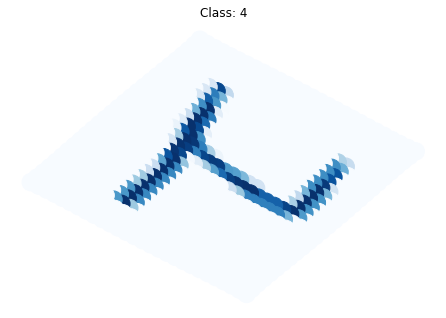

<Figure size 720x216 with 0 Axes>

In [7]:
import random
showGraph(*trainset[random.randrange(10)])

# ChebNetDGL

## Functions for Chebychev Polynoms

In [8]:
# stolen code over here
# class definitions
class my_sparse_mm(torch.autograd.Function):
    """
    Implementation of a new autograd function for sparse variables, 
    called "my_sparse_mm", by subclassing torch.autograd.Function 
    and implementing the forward and backward passes.
    """
    
    @staticmethod
    def forward(self, W, x):  # W is SPARSE
        self.save_for_backward(W, x)
        y = torch.mm(W, x)
        return y
    
    @staticmethod
    def backward(self, grad_output):
        W, x = self.saved_tensors 
        grad_input = grad_output.clone()
        grad_input_dL_dW = torch.mm(grad_input, x.t()) 
        grad_input_dL_dx = torch.mm(W.t(), grad_input )
        return grad_input_dL_dW, grad_input_dL_dx
    

In [34]:
def rescale_L(L, lmax=2):
    """
    Rescale the Laplacian eigenvalues in [-1,1]. 
    here implemented for torch
    """
    M, M = L.shape
    I = torch.eye(M)
    L = torch.div(L, (lmax / 2))
    L = L - I
    return L


def chebyshev(L, X, K):
    """Return T_k X where T_k are the Chebyshev polynomials of order up to K.
    Complexity is O(KMN).
    -  - - - - - - - - - 
    - Here implemented for torch
    - Change to sparse torch?
    - Rescaled L needed
    - try no grad?
    """
    M, N = X.shape
    assert L.dtype == X.dtype
    '''
    # L = rescale_L(L, lmax)
    # Xt = T @ X: MxM @ MxN.
    # Xt_0 = T_0 X = I X = X.
    # Xt_1 = T_1 X = L X.
    # Xt_k = 2 L Xt_k-1 - Xt_k-2.

    Xt = torch.empty((K, M, N), dtype=L.dtype)

    Xt[0, :] = X
    if K > 1:
        Xt[1, ...] = torch.mm(L, X)t
        #Xt[1, ...] = my_sparse_mm.apply(L, X)
        for k in range(2, K):
            var = 2 * torch.mm(L, Xt[k-1, :]) - Xt[k-2, :]
            Xt[k, :] = var
    return Xt

    '''
    x0 = X
    x = x0.unsqueeze(0)
    if K > 1:
        x1 = torch.mm(L, x0)              # V x Fin*B
        x = torch.cat((x, x1.unsqueeze(0)), 0)  # 2 x V x Fin*B
    for k in range(2, K):
        x2 = 2 * torch.mm(L, x1) - x0
        x = torch.cat((x, x2.unsqueeze(0)), 0)  # M x Fin*B
        x0, x1 = x1, x2
    
    return x

[autoreload of utils failed: Traceback (most recent call last):
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
 

In [39]:
def showChebFilters(graph, label, K):
    '''
    Function to visualise the signal of the handwritten digits over a lattice graph
    '''
    t = time.time()
    nx_G = graph.to_networkx().to_undirected()
    elapsed = time.time() - t
    print('it takes', elapsed, ' to transfer the graph to nX')
    t = time.time()
    Xt = chebyshev(rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
        graph.to_networkx().to_undirected()).todense()).float()), graph.ndata['h'].view(-1, 1), K)
    elapsed = time.time() - t
    print('it takes', elapsed, ' to transfer the graph to calculate all Xts')
    t = time.time()
    # Kamada-Kawaii layout
    pos = nx.kamada_kawai_layout(nx_G)
    elapsed = time.time() - t
    print('it takes', elapsed, ' to calculate the position of the nodes')

    plt.suptitle('Class: {:d}'.format(label), fontsize=12)
    plt.subplot(231)
    plt.title('Chebynome order 0')
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=Xt[0].view(-1))

    plt.subplot(232)
    plt.title('Chebynome order 1')
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=Xt[1].view(-1))

    plt.subplot(233)
    plt.title('Chebynome order 2')
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=Xt[2].view(-1))

    plt.subplot(234)
    plt.title('Chebynome order 3')
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=Xt[3].view(-1))
    plt.subplot(235)
    plt.title('Chebynome order 4')
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=Xt[4].view(-1))
    plt.subplot(236)
    plt.title('Chebynome order 5')
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=Xt[5].view(-1))
    plt.show()


it takes 0.02488112449645996  to transfer the graph to nX
it takes 0.0408329963684082  to transfer the graph to calculate all Xts
it takes 8.066170930862427  to calculate the position of the nodes


/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


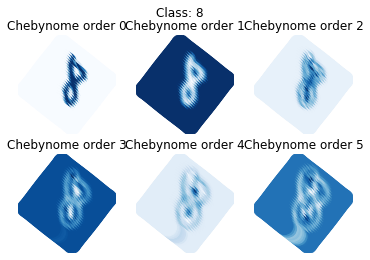

In [40]:
gtest, ltest = trainset[random.randrange(20)]

showChebFilters(gtest, ltest, K=6)

# Model

## Convolution layer
Define a Convolution module that uses this

In [12]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')


def reduce(nodes):
    """Take a sum over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.sum(nodes.mailbox['m'], 1)
    return {'h': accum}


class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""

    def __init__(self, in_feats, out_feats, activation, bias=True):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats, bias)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h': h}


class Chebyconv(nn.Module):
    def __init__(self, in_feats, out_feats, k, bias=True):
        super(Chebyconv, self).__init__()
        # Parameters
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self.L = None
        # Convlayer
        self.apply_mod = NodeApplyModule(
            in_feats*k, out_feats, activation=F.relu)

        ##
        # NEED TO MAKE A PARAMETER INITIALIZER /!\
        ##

    def forward(self, g, feature):
        V, featmaps = feature.size()

        # This line is way too long computationally! ----------------------
        self.L = rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
            g.to_networkx().to_undirected()).todense()).float())

        Xt = torch.Tensor([])
        for fmap in range(featmaps):
            Xt = torch.cat((Xt, chebyshev(
                self.L, feature[:, fmap].view(-1, 1), self._k)), 0)
        g.ndata['h'] = Xt.view(V, -1)
         g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

## Convolution layer and classifier


In [13]:
import torch.nn.functional as F

# NEED TO CODE A WEIGHT INITIALIZER

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.layers = nn.ModuleList([
            # HARD CODE THIS FOR THE MOMENT
            Chebyconv(in_feats=1, out_feats=32, k=5),
            Chebyconv(in_feats= 32, out_feats=hidden_dim, k=5)])

        self.classify = nn.Sequential(
            #nn.Linear(hidden_dim, 20),
            #nn.ReLU(inplace=True),
            #nn.Dropout(), ## Add dropout when there will be enough features
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, g):
        h = g.ndata.pop('h').view(-1, 1)
        # print('h,size',h,h.size())
        for conv in self.layers:
            h = conv(g, h)

        g.ndata['h'] = h
        # print('h2,size',h,h.size())
        hg = dgl.mean_nodes(g, 'h')
        # print('hg,size',hg,hg.size())
        return self.classify(hg)

In [14]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# Debug section
Verifying all of the steps

In [15]:
g, l = trainset[0]
L = rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
    g.to_networkx().to_undirected()).todense()).float())

Xt = chebyshev(L, g.ndata['h'].view(-1, 1), 5)  # [k,v,1]

In [39]:
g, l = collate((trainset[0], trainset[1]))
net = Classifier(1, 512, trainset.num_classes)
print("-------------------- Network model --------------------\n", net)
print("\n --------------------  Output for graph g:  --------------------\n", net(g))

-------------------- Network model --------------------
 Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=5, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=160, out_features=512, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

 --------------------  Output for graph g:  --------------------
 tensor([[ 0.1377,  0.0047, -0.1146, -0.0497,  0.0690, -0.0800, -0.0833,  0.0378,
         -0.1155, -0.0772],
        [ 0.1575,  0.0076, -0.1322, -0.0540,  0.0776, -0.0975, -0.0948,  0.0409,
         -0.1326, -0.0761]], grad_fn=<AddmmBackward>)


# Model definition for training

In [21]:
net = Classifier(1, 52, trainset.num_classes)
print(net)
if torch.cuda.is_available():
    net.cuda()

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=5, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=160, out_features=52, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=52, out_features=10, bias=True)
  )
)


# Training pipe

In [17]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=2,
                         shuffle=True, collate_fn=collate)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training time

In [18]:
epoch_losses = []
net.train()
torch.autograd.set_detect_anomaly(True)
for epoch in range(30):
    epoch_loss = 0
    t = time.time()
    for iter, (bg, label) in enumerate(data_loader):
        prediction = net(bg)
        # print("Prediction:", prediction,'len:',prediction.size())  #DEBUG
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward() 
        
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}, in {:.2f}(s) '.format(
        epoch, epoch_loss, time.time()-t))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.3227, in 245.39(s) 


KeyboardInterrupt: 

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Test Metrics

In [30]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report
# Change 

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(net(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

#sklearn.metrics.classification_report(test_Y,argmax_Y)

print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 0.0000%
Accuracy of argmax predictions on the test set: 20.000000%


## Saving

In [25]:
from utils import save_model
save_model('Model1', net)

# Others

$h_i^{l+1}$ &= $\sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}$

$Z^{0, l}$ &= $H^{l}$

$Z^{1, l}$ &=$ \hat{L} \cdot H^{l}$

$Z^{k, l}$ &= $2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}$

$\hat{L}$ &= $2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I$

    Parameters
    ----------
    in_feats: int
        Number of input features.
    out_feats: int
        Number of output features.
    k : int
        Chebyshev filter size.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.